# Growth rate methods comparison
This notebook compares different methods for the calculation of specific growth rates.
Specifically, it demonstrates the impact of different calibration strategies and compares our new $\vec{\mu}_t$ method with a spline-based $\mu(t)$ approach.

In [1]:
import ipywidgets
from matplotlib import cm, pyplot
import pandas
import pathlib
import arviz
import pathlib
import pymc3
import numpy
import copy

import bletl
import bletl.growth
import calibr8

# Some code was outsourced to sister files
import models
import plotting

DP_DATA = pathlib.Path("..", "data")
DP_RESULTS = pathlib.Path("..", "results")

## Calibration models
Based on the BioLector calibration dataset and corresponding model from the [calibr8-paper](https://github.com/JuBiotech/calibr8-paper),
the next cell creates various versions flavors of calibration models that are commonly used with microbioreactors.

In [2]:
class LinearWithFixedIntercept(calibr8.BaseModelT):
    def __init__(self, blank=0):
        self.blank = blank
        theta_names = ('slope', 'scale', 'df')
        super().__init__(independent_key='X', dependent_key='Pahpshmir_1400_BS3_CgWT', theta_names=theta_names)

    def predict_dependent(self, x, *, theta=None):
        if theta is None:
            theta = self.theta_fitted
        slope, scale, df = theta
        mu = x * slope + self.blank
        return mu, scale, df

    def predict_independent(self, y, *, theta=None):
        if theta is None:
            theta = self.theta_fitted
        slope, scale, df = theta
        return (y - self.blank) / slope
    

class LinearModel(calibr8.BasePolynomialModelT):
    def __init__(self):
        super().__init__(
            independent_key="X",
            dependent_key="Pahpshmir_1400_BS3_CgWT",
            mu_degree=1,
            scale_degree=0,
        )

    
def get_linear_model(*, fix_intercept:bool, xmin=0.01, xmax=30):
    mask = numpy.logical_and(cm_cdw.cal_independent > xmin, cm_cdw.cal_independent < xmax)
    
    if fix_intercept:
        cmodel = LinearWithFixedIntercept(blank=cm_cdw.predict_dependent(0)[0])
        theta_guess = numpy.array([2, 1, 5]).astype(float)
        theta_bounds=[
            (0, 5),
            (0.001, 5),
            (1, 50)
        ]
    else:
        cmodel = LinearModel()
        theta_guess = numpy.array([0.5, 2, 1, 5]).astype(float)
        theta_bounds=[
            (-10, 4),
            (0, 5),
            (0.001, 5),
            (1, 50)
        ]

    calibr8.fit_scipy(
        cmodel,
        independent=cm_cdw.cal_independent[mask],
        dependent=cm_cdw.cal_dependent[mask],
        theta_guess=theta_guess,
        theta_bounds=theta_bounds,
        
    )
    return cmodel

cm_cdw = models.get_biomass_calibration()
cm_cdw_linear6 = get_linear_model(fix_intercept=True, xmax=6)
cm_cdw_linear10 = get_linear_model(fix_intercept=True, xmax=10)
cm_cdw_linear6to30 = get_linear_model(fix_intercept=False, xmin=6, xmax=30)

cmodels = {
    "logistic": cm_cdw,
    "linear < 6 g/L": cm_cdw_linear6,
    "linear < 10 g/L": cm_cdw_linear10,
    "linear 6-30 g/L": cm_cdw_linear6to30,
}

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:708: RuntimeWarning: divide by zero encountered in log10
  y = (numpy.exp(s2 * (s3 * (log_I_x - numpy.log10(x)) + c / s2)) + 1) ** -s1
Parameter df (50.0) is close to its upper bound (50).
Fit of LinearWithFixedIntercept has failed:
      fun: 41.34550836186292
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.06057395e-05, -6.39488463e-06, -2.34123812e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 192
      nit: 28
     njev: 48
   status: 0
  success: True
        x: array([ 1.05433495,  0.26378326, 50.        ])


## Plot the various flavors of calibration models

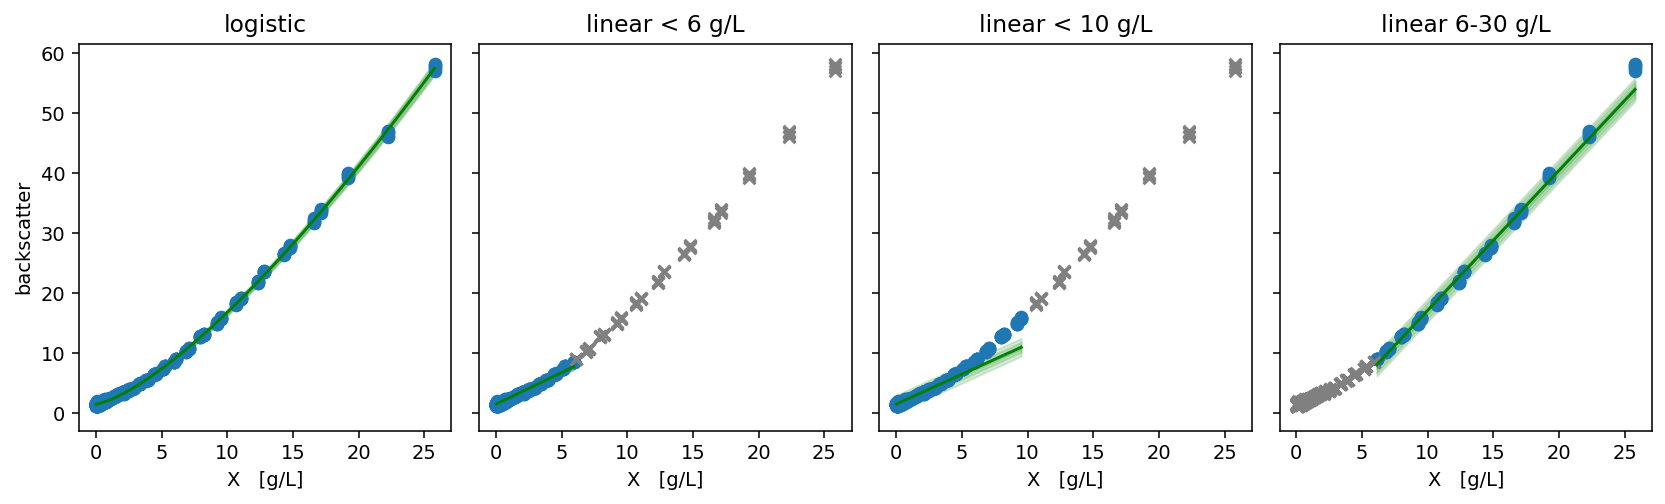

In [3]:
fig_waste, ax_waste = pyplot.subplots()
fig, axs = pyplot.subplots(dpi=140, ncols=4, figsize=(12, 3.7), sharey=True, sharex=True)

for i, (title, cmodel) in enumerate(cmodels.items()):
    calibr8.plot_model(cmodel, axs=[axs[i], ax_waste, ax_waste])
    mask = numpy.isin(cm_cdw.cal_independent, cmodel.cal_independent)
    axs[i].scatter(
        cm_cdw.cal_independent[~mask],
        cm_cdw.cal_dependent[~mask],
        color="gray", marker="x"
    )
    axs[i].set(
        title=title,
        ylabel="backscatter" if i == 0 else None,
        xlabel="X   [g/L]"
    )

pyplot.close(fig_waste)
fig.tight_layout()
fig.savefig(DP_RESULTS / "fig_calibrations.pdf")
fig.savefig(DP_RESULTS / "fig_calibrations.png")
pyplot.show()

## Loading experimental data

In [4]:
bldata = bletl.parse(DP_DATA / "8X4PF4.csv")
df_inductions = pandas.read_excel(
    DP_DATA / "8X4PF4_eventlog.xlsx",
    index_col=0, sheet_name="inductions"
).set_index("well").sort_index()
df_samplings = pandas.read_excel(
    DP_DATA / "8X4PF4_eventlog.xlsx",
    index_col=0, sheet_name="samplings"
).set_index("well").sort_index()

The next selects one well for which we'll make the comparison.

In [5]:
well = "F02"

t, bs = bldata["BS3"].get_timeseries(
    well,
    last_cycle=df_samplings.loc[well, "cycle"]
)

# Apply the Spline method

In [6]:
mu_spline_bs = bletl.splines.get_mue(
    bldata["BS3"], wells=[well],
    # The prediction of the most detailed calibration model
    # is the most exact blank value we have:
    blank=cm_cdw.predict_dependent(0)[0],
    last_cycle=df_samplings.loc[well, "cycle"]
)

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:708: RuntimeWarning: divide by zero encountered in log10
  y = (numpy.exp(s2 * (s3 * (log_I_x - numpy.log10(x)) + c / s2)) + 1) ** -s1


# Apply the $\vec{\mu}_t$ method with different calibrations
The next cell runs optimization and MCMC of the $\vec{\mu}_t$ model with all the different calibration models.

In [7]:
results = {}

for title, cmodel in cmodels.items():
    print(f"Running with {title} calibration")
    results[title] = bletl.growth.fit_mu_t(
        t, bs,
        cmodel,
        switchpoints={},   # Not providing and prior switchpoint information
        student_t=True,    # and turning on automatic switchpoint detection.
        drift_scale=0.0025,
        mu_prior=0.4,
    )
    fp_trace = pathlib.Path(title.replace("<", "below").replace(" g/L", "") + ".nc")
    if not fp_trace.exists():
        print("Sampling...")
        results[title].sample(tune=5000, draws=10_000, target_accept=0.97)
        results[title].idata.to_netcdf(fp_trace)
    else:
        print("Loading from disk...")
        results[title]._idata = arviz.from_netcdf(fp_trace)

Running with logistic calibration


C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\bletl_env\lib\site-packages\calibr8\core.py:746: RuntimeWarning: invalid value encountered in power
  x_hat = - (x1**(-x1*x3) * numpy.log( ((1/y)**x0 - 1) * numpy.exp(-x0*x4+x2-x4) ) ) / s



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 5_000 tune and 10_000 draw iterations (15_000 + 30_000 draws total) took 550 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Running with linear < 6 g/L calibration



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 5_000 tune and 10_000 draw iterations (15_000 + 30_000 draws total) took 875 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Running with linear < 10 g/L calibration



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 5_000 tune and 10_000 draw iterations (15_000 + 30_000 draws total) took 371 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Running with linear 6-30 g/L calibration



Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_t__diff_]


Sampling 3 chains for 5_000 tune and 10_000 draw iterations (15_000 + 30_000 draws total) took 426 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Show the results with the logistic model separately
This first visualization compares the full posterior obtained by MCMC with the MAP estimate obtained by optimization.

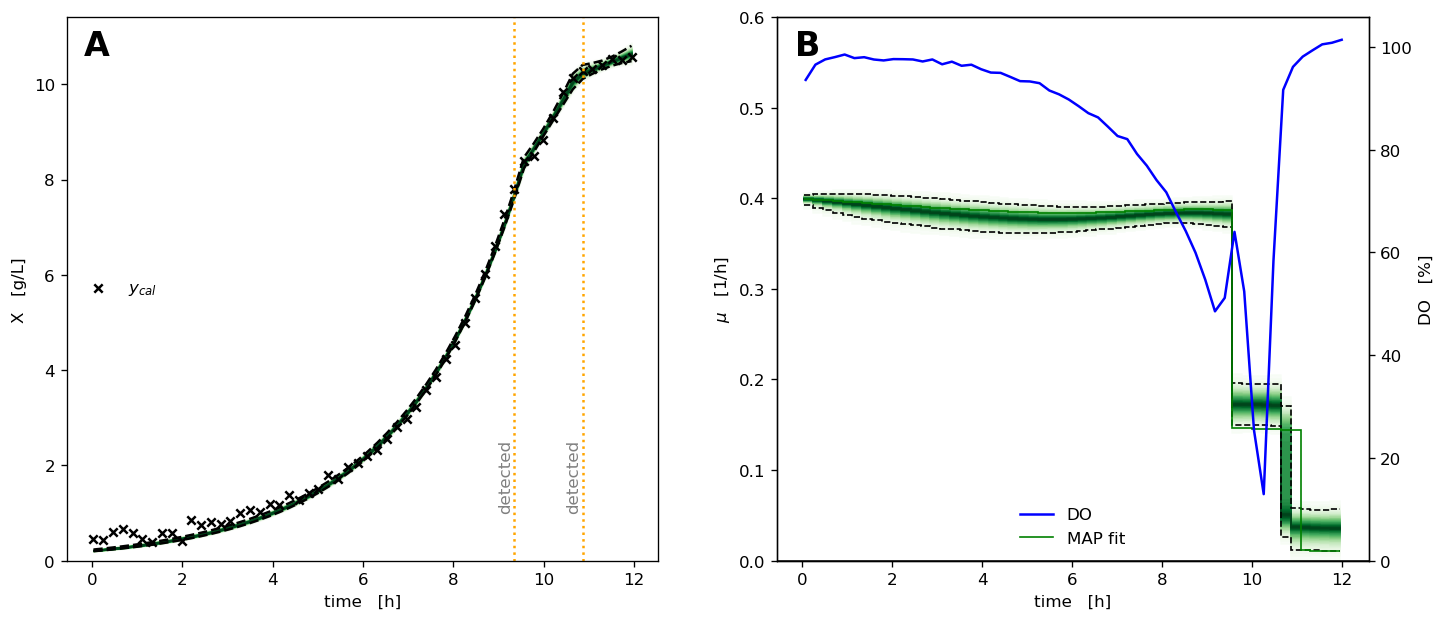

In [8]:
fig, axs = pyplot.subplots(ncols=2, figsize=(14,6), dpi=120)

ax = axs[0]
result = results["logistic"]
plotting.plot_density(
    ax=ax,
    x=result.t_data,
    samples=result.x_mcmc,
    plot_samples=False,
    palette=cm.Greens
)
ax.scatter(t, cm_cdw.predict_independent(bs), s=25, label='$y_{cal}$', marker='x', color='black')
ax.set(
    ylabel="X   [g/L]",
    xlabel="time   [h]",
    ylim=(0, None),
)
ax.legend(loc="center left", frameon=False)

# draw vertical lines at switchpoints
for t_switch, label in result.switchpoints.items():
    ax.axvline(t_switch, linestyle=':', color='orange', label=label)
    ax.text(
        t_switch, 1,
        s=f'{label}\n',
        color="gray",
        rotation=90,
        horizontalalignment="center",
        verticalalignment='bottom',
    )

ax = axs[1]
plotting.plot_density(
    ax=ax,
    x=result.t_data,
    samples=result.mu_mcmc,
    plot_samples=False,
    palette=cm.Greens
)
ax.stairs(result.mu_map, result.t_data, color='green', label='MAP fit', baseline=None)
ax.axhline(0, color="black")

ax.plot([], [], color="blue", label="DO")
ax.legend(frameon=False, loc="lower center")

ax.set(
    ylim=(0, 0.6),
    xlabel="time   [h]",
    ylabel="$\mu$   [1/h]",
)

# plot the DO curve for comparison
tdo, do = bldata.get_timeseries("DO", well, last_cycle=df_samplings.loc[well, "cycle"])
ax2 = ax.twinx()
ax2.plot(
    *bldata["DO"].get_timeseries(well, last_cycle=df_samplings.loc[well, "cycle"]),
    color='blue', label='MAP fit'
)
ax2.set(
    ylim=(0, None),
    ylabel="DO   [%]",
)

# zoom in on the switchpoints
#left.set_xlim(13,18)

for ax, letter in zip(axs.flatten(), "AB"):
    ax.text(0.03, 0.93, letter, transform=ax.transAxes, size=20, weight="bold")

fig.savefig(DP_RESULTS / "fig_mut_mcmc.pdf", bbox_inches="tight")
fig.savefig(DP_RESULTS / "fig_mut_mcmc.png", bbox_inches="tight")
pyplot.show()

## Prepare a comparison of results with different calibrations

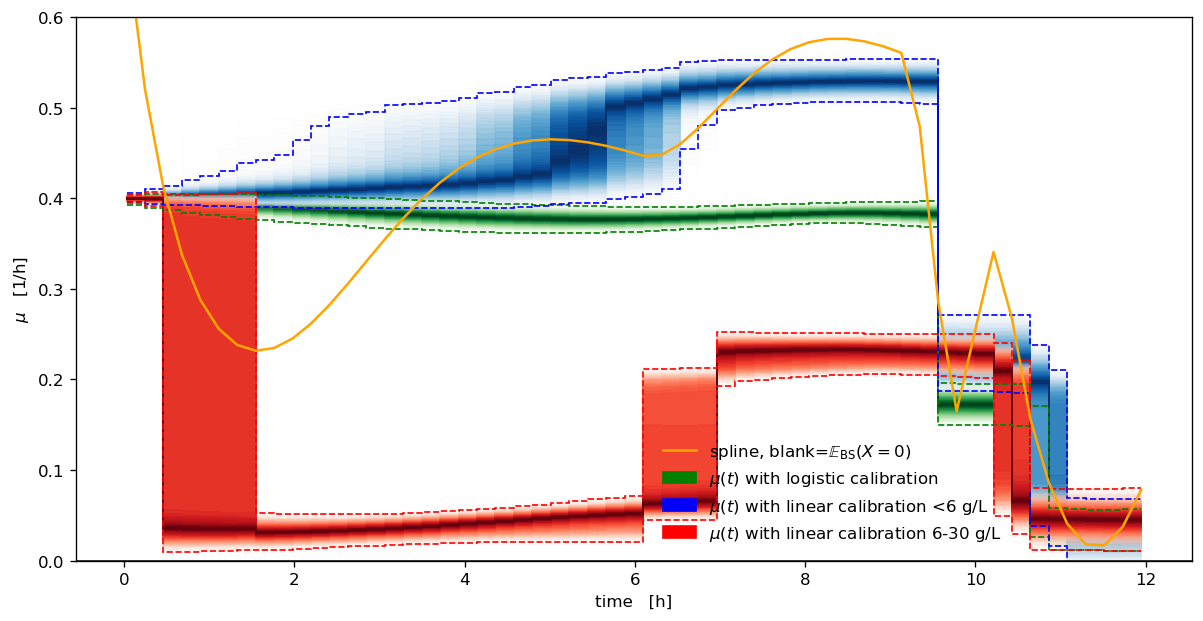

In [12]:
fig, ax = pyplot.subplots(figsize=(12,6), dpi=120)

ax = ax
# Plot the results from different methods
plotting.plot_density(
    ax=ax,
    x=results["logistic"].t_data,
    samples=results["logistic"].mu_mcmc,
    plot_samples=False,
    palette=plotting.transparentify(cm.Greens),
    fill_alpha=None,
    percentile_kwargs=dict(color="green"),
)
plotting.plot_density(
    ax=ax,
    x=results["linear < 6 g/L"].t_data,
    samples=results["linear < 6 g/L"].mu_mcmc,
    plot_samples=False,
    palette=plotting.transparentify(cm.Blues),
    fill_alpha=None,
    percentile_kwargs=dict(color="blue"),
)
plotting.plot_density(
    ax=ax,
    x=results["linear 6-30 g/L"].t_data,
    samples=results["linear 6-30 g/L"].mu_mcmc,
    plot_samples=False,
    palette=plotting.transparentify(cm.Reds),
    fill_alpha=None,
    percentile_kwargs=dict(color="red"),
)
ax.plot(*mu_spline_bs.get_timeseries(well), color="orange", label="spline, blank=$\mathbb{E}_\mathrm{BS}(X = 0)$")

ax.axhline(0, color="black")
ax.set(
    ylim=(0, 0.6),
    xlabel="time   [h]",
    ylabel="$\mu$   [1/h]",
)

ax.fill_between([], [], [], color="green", label="$\mu(t)$ with logistic calibration")
ax.fill_between([], [], [], color="blue", label="$\mu(t)$ with linear calibration <6 g/L")
ax.fill_between([], [], [], color="red", label="$\mu(t)$ with linear calibration 6-30 g/L")
ax.legend(frameon=False, loc=[0.52, 0.02])

fig.savefig(DP_RESULTS / "fig_mut_comparison.pdf", bbox_inches="tight")
fig.savefig(DP_RESULTS / "fig_mut_comparison.png", bbox_inches="tight")
pyplot.show()

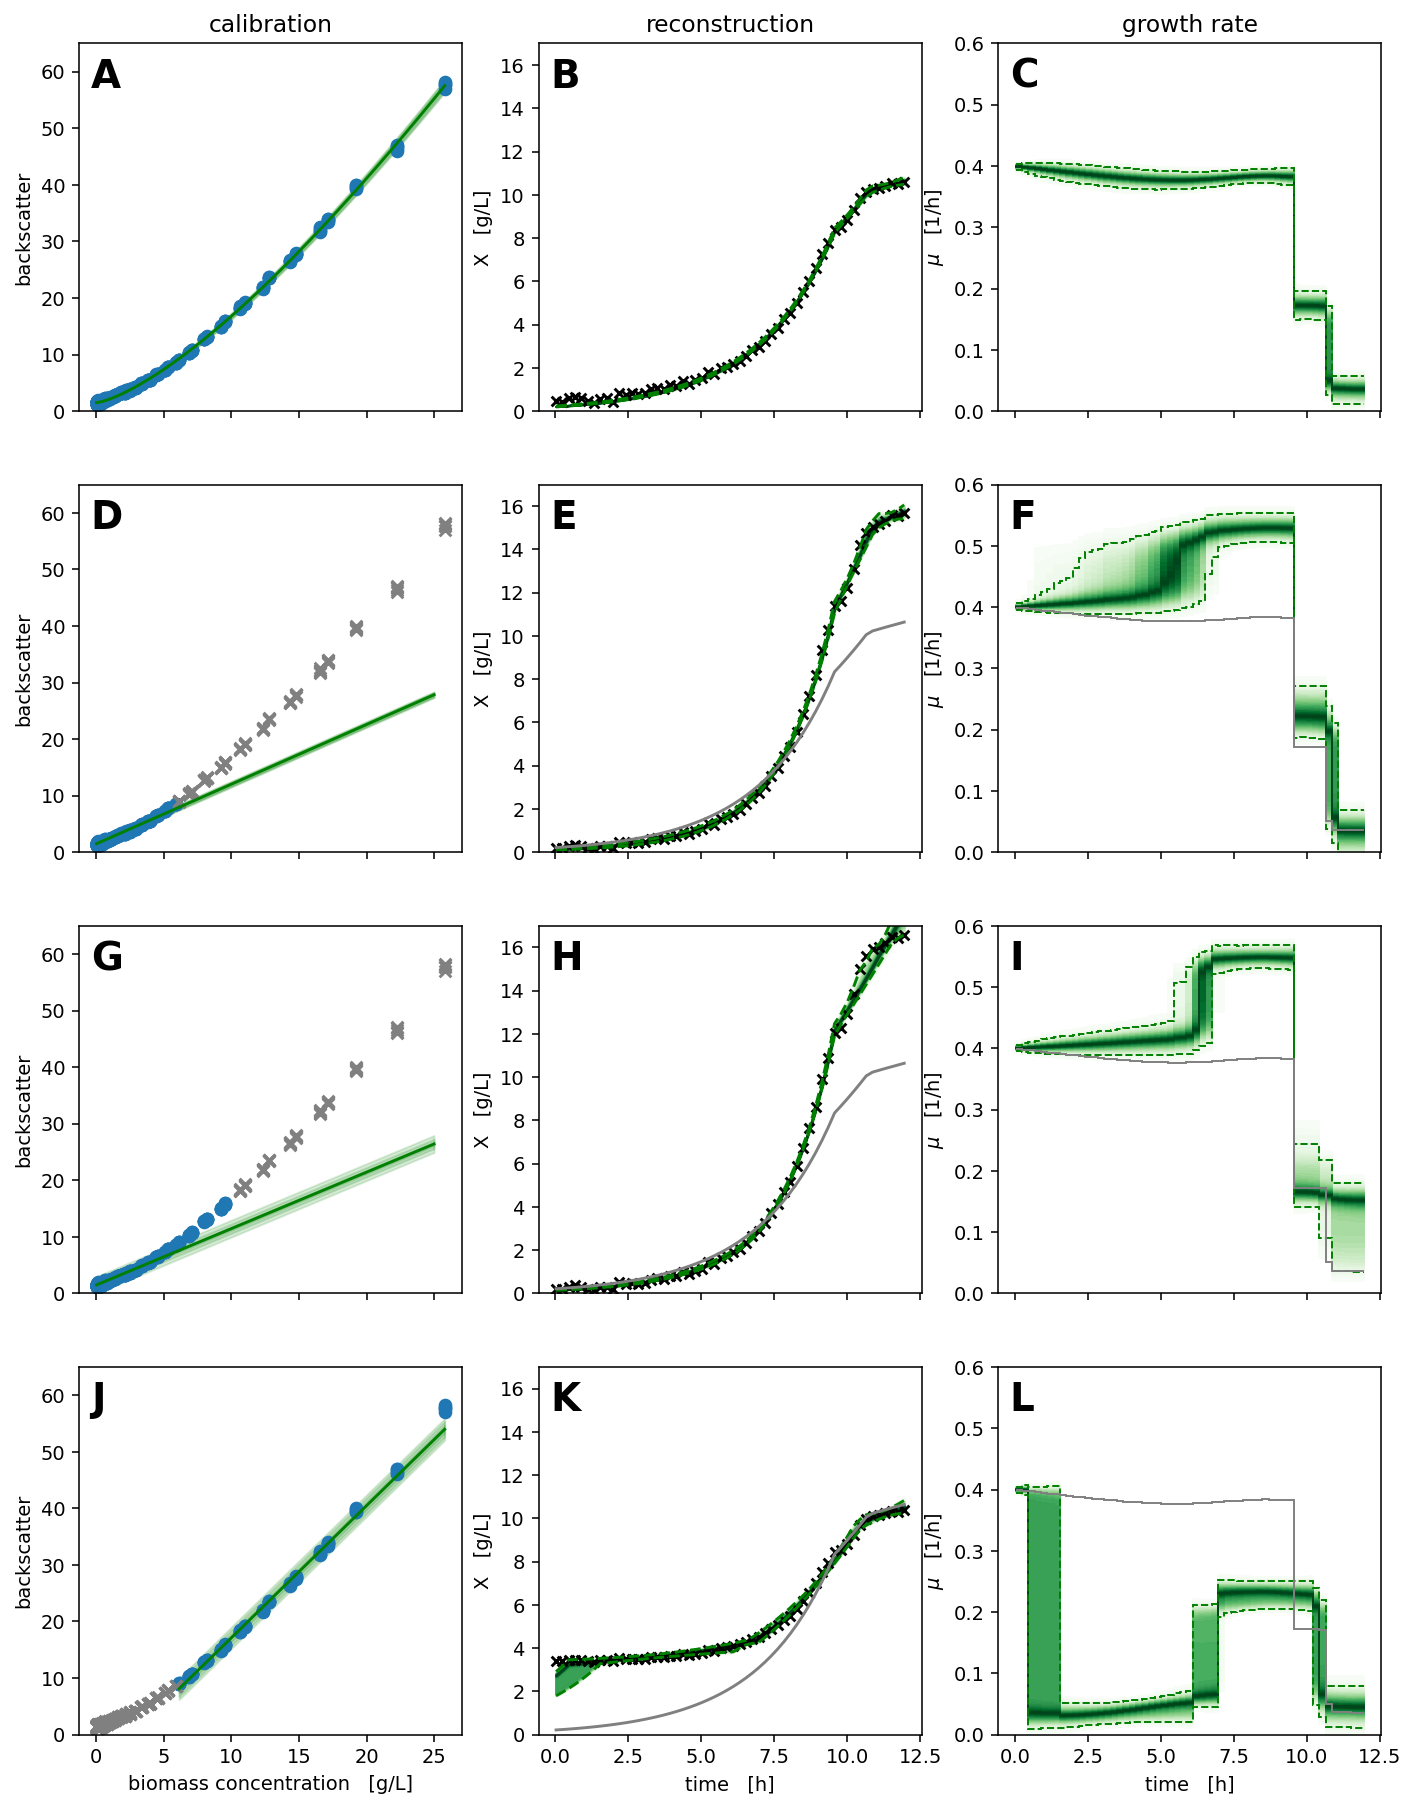

In [16]:
def plot_row(axr, cmodel, res, xlabel=True):
    fig_waste, ax_waste = pyplot.subplots()
    
    ax = axr[0]
    
    # trick the plotting function into drawing a longer band
    # by appending a data point that lies outside of the ylimits
    cmodel = copy.deepcopy(cmodel)
    cmodel.cal_independent = numpy.append(cmodel.cal_independent, [25])
    cmodel.cal_dependent = numpy.append(cmodel.cal_dependent, [70])
    calibr8.plot_model(cmodel, axs=[ax, ax_waste, ax_waste])    
    mask = numpy.isin(cm_cdw.cal_independent, cmodel.cal_independent)
    ax.scatter(
        cm_cdw.cal_independent[~mask],
        cm_cdw.cal_dependent[~mask],
        color="gray", marker="x"
    )
    ax.set(
        ylim=(0, 65),
        ylabel="backscatter",
        xlabel="biomass concentration   [g/L]" if xlabel else "",
    )

    ax = axr[1]
    plotting.plot_density(
        ax=ax,
        x=res.t_data,
        samples=res.x_mcmc,
        plot_samples=False,
        palette=cm.Greens,
        percentile_kwargs=dict(color="green"),
    )
    ax.scatter(t, cmodel.predict_independent(bs), s=25, label='$y_{cal}$', marker='x', color='black')
    ax.set(
        ylabel="X   [g/L]",
        xlabel="time   [h]" if xlabel else "",
        ylim=(0, 17),
    )
    
    ax = axr[2]
    plotting.plot_density(
        ax=ax,
        x=res.t_data,
        samples=res.mu_mcmc,
        plot_samples=False,
        palette=cm.Greens,
        percentile_kwargs=dict(color="green"),
    )
    ax.set(
        ylabel="$\mu$   [1/h]",
        xlabel="time   [h]" if xlabel else "",
        ylim=(0, 0.6),
    )
    
    pyplot.close(fig_waste)
    return

fig, axs = pyplot.subplots(ncols=3, nrows=4, figsize=(12, 16), dpi=140, sharex="col", sharey="col")

axs[0, 0].set_title("calibration")
axs[0, 1].set_title("reconstruction")
axs[0, 2].set_title("growth rate")

for r, (title, result) in enumerate(results.items()):
    plot_row(axs[r, :], cmodels[title], results[title], xlabel=r == len(results) - 1)
    axs[r, 0].text(0.05, 0.95, title, fontsize=12, ha="left", va="top", transform=axs[r, 1].transAxes)


# draw the top ones for reference
result = results["logistic"]
for ax in axs[1:, 1]:
    ax.plot(result.t_data, numpy.median(result.x_mcmc, axis=0), ls="-", color="gray")
for ax in axs[1:, 2]:
    ax.stairs(numpy.median(result.mu_mcmc, axis=0), result.t_data, ls="-", color="gray", baseline=None)
    
for ax, letter in zip(axs.flatten(), "ABCDEFGHIJKL"):
    ax.text(0.03, 0.88, letter, transform=ax.transAxes, size=20, weight="bold")

fig.savefig(DP_RESULTS / "si_mut_comparison.pdf", bbox_inches="tight")
fig.savefig(DP_RESULTS / "si_mut_comparison.png", bbox_inches="tight")
pyplot.show()

In [11]:
%load_ext watermark
%watermark

Last updated: 2021-08-20T14:21:23.593474+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.26.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

